In [1]:
%load_ext rpy2.ipython

In [2]:
import numpy as np
import os
import pandas as pd
import gensim.downloader as api

from sklearn.feature_extraction.text import CountVectorizer

In [3]:
#import jax
#import jax.numpy as jnp

## Global flag to set a specific platform, must be used at startup.
#jax.config.update('jax_platform_name', 'cpu')

In [4]:
%%R
library(rstan)
library(tidyverse)
library(lubridate)
library(gridExtra)
library(quanteda)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   4.0.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::%||%()    masks base::%||%()
✖ tidyr::extract() masks rstan::extract()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


要求されたパッケージ StanHeaders をロード中です

rstan version 2.32.5 (Stan version 2.32.2)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)


次のパッケージを付け加えます: ‘gridExtra’

以下のオブジェクトは ‘package:dplyr’ からマスクされています:

    combine

Package version: 4.3.1
Unicode version: 14.0
ICU version: 70.1
Parallel computing: disabled
See https://quanteda.io for tutorials and examples.


In [5]:
%%R
load("../data/YoungSoroka.2012.Rdata")

ys <- YS %>% 
  as_tibble() %>% 
  filter(topic == 'Economy') %>%
  #filter(topic == 'Foreign') %>%
  mutate(date = ymd(str_c(year, month, day))) %>% 
  mutate(is_pos_1 = if_else(code_1 == 'Positive', TRUE, FALSE)) %>% 
  mutate(is_neg_1 = if_else(code_1 == 'Negative', TRUE, FALSE)) %>% 
  mutate(is_pos_2 = if_else(code_2 == 'Positive', TRUE, FALSE)) %>% 
  mutate(is_neg_2 = if_else(code_2 == 'Negative', TRUE, FALSE)) %>% 
  mutate(is_pos_3 = if_else(code_3 == 'Positive', TRUE, FALSE)) %>% 
  mutate(is_neg_3 = if_else(code_3 == 'Negative', TRUE, FALSE)) %>% 
  mutate(n_pos = is_pos_1 + is_pos_2 + is_pos_3) %>% 
  mutate(n_neg = is_neg_1 + is_neg_2 + is_neg_3) %>%
  mutate(scale = if_else(n_pos == 3, 5, if_else(n_pos ==2, 4, if_else(n_neg == 2, 2, if_else(n_neg == 3, 1, 3)))))

corpus <- corpus(ys, text_field = 'body')

toks <- corpus %>% 
  #  corpus_reshape("sentences") %>% 
  tokens(remove_punct = TRUE, remove_symbols = TRUE, 
         remove_numbers = TRUE, remove_url = TRUE) %>% 
  tokens_remove(stopwords("en", source = "marimo")) %>% 
  tokens_remove(min_nchar = 2) %>% 
  tokens_remove(c("*-time", "*-timeUpdated", "GMT", "BST", "*.com")) %>% 
  tokens_tolower()

mx <- toks %>% 
  dfm()

D = ndoc(mx)
V = nfeat(mx)

df <- convert(mx, to = "data.frame")
df <- as_tibble(rownames_to_column(df, "Id"))

cols <- colnames(df)
vocab <- cols[3:length(cols)]

In [6]:
%R -o toks,vocab

In [7]:
r_toks = [toks[k] for k in toks.keys()]
r_vocab = list(vocab)

In [8]:
def get_YS_data(r_toks, r_vocab):
  docs = []
  for toks in r_toks:
      docs.append(' '.join([r_vocab[token_id-1] for token_id in toks]))
  
  lowercase=True
  max_df=1.0
  min_df=3
  max_features=None
  
  cv = CountVectorizer(binary=False, lowercase=lowercase, max_df=max_df, min_df=min_df, max_features=max_features)
  BoW = cv.fit_transform(docs).toarray()
  
  word2id = cv.vocabulary_
  vocab = cv.get_feature_names_out()
  
  expand_freq = False
  
  M = len(BoW)
  V = len(vocab)
  if expand_freq:
    # expand n_dv as duplicate rows
    doc_ids, token_ids = [], []
    for d, doc in enumerate(docs):
        for token in doc.strip().split():
            if token in word2id:
              doc_ids.append(d)
              token_ids.append(word2id[token])
  
    N = len(token_ids)
    W = token_ids
    D = doc_ids
  else:
    data_index = np.where(BoW.ravel() > 0)[0]
    N = len(data_index)
    N_dv = BoW.ravel()[data_index]
    D = (data_index/V).astype(int)
    W = data_index%V
  
  p_v = np.sum(BoW, axis=0)/np.sum(BoW)
  
  return N, M, V, D, W, p_v, vocab, word2id

In [9]:
def get_plss_phi(pos_words, neg_words, wv, vocab):

    normed_vec = wv.get_normed_vectors()
    key2index = wv.key_to_index
        
    def calc_beta(pos_words, neg_words):
        def mean_vec(words):
            return np.array([normed_vec[key2index[v]] for v in words if v in key2index]).mean(axis=0)
        
        beta = mean_vec(pos_words) - mean_vec(neg_words)
        beta = beta/np.linalg.norm(beta)
        return beta

    beta = calc_beta(pos_words, neg_words)  
    phi = [(v, beta @ normed_vec[key2index[v]] if v in key2index else 0) for v in vocab]
    return phi


def get_phi_val(pred):
    return np.array([e[1] for e in pred])

In [10]:
N, M, V, D, W, p_v, vocab, word2id = get_YS_data(r_toks, r_vocab)

In [11]:
pos_words = ['good', 'nice', 'excellent', 'positive', 'fortunate', 'correct', 'superior']
neg_words = ['bad', 'nasty', 'poor', 'negative', 'unfortunate', 'wrong', 'inferior']

In [12]:
wv_model = api.load("glove-wiki-gigaword-300")
phi = get_phi_val(get_plss_phi(pos_words, neg_words, wv_model, vocab))

In [13]:
## imbalanced polarity words
#pos_words = [w[0] for w in sorted([(w, wv_model.similarity('good', w)) for w in pos_words], key=lambda x: x[1])[:3]]
#neg_words = [w[0] for w in sorted([(w, wv_model.similarity('bad', w)) for w in neg_words], key=lambda x: x[1])[-3:]]
#pos_words, neg_words

In [14]:
# MCMC (numpyro)

In [15]:
#os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
#os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform'
#os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.7'

In [16]:
import numpy as np
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist

from jax import random
from numpyro.infer import MCMC, NUTS

#numpyro.set_host_device_count(3)

In [17]:
def model(data):
    M, N, V, D, W, p_v, phi = data
#    theta = numpyro.sample('theta', dist.Normal(np.zeros(M), np.ones(M)))
    with numpyro.plate('M', M):
        theta = numpyro.sample('theta', dist.Normal(0, 1))
    W = jnp.asarray(W)
    D = jnp.asarray(D)
    proj = jnp.ones((N, V))
    with numpyro.plate('N', N) as n:
#        numpyro.sample('obs', dist.CategoricalLogits(p_v + phi), obs=W)
        theta_n = (theta[D] * proj.T).T
        logits = p_v + phi * theta_n
        numpyro.sample('obs', dist.CategoricalLogits(logits), obs=W)

In [18]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000, num_chains=3)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, (M, N, V, D, W, p_v, phi), extra_fields=('potential_energy',))

/tmp/ipykernel_2841/4025211663.py:2: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000, num_chains=3)
sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [1:41:05<00:00,  4.04s/it, 15 steps of size 2.94e-01. acc. prob=0.87]


In [19]:
mcmc.print_summary()
pe = mcmc.get_extra_fields()['potential_energy']
print('Expected log joint density: {:.2f}'.format(np.mean(-pe)))


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  theta[0]     -0.40      0.74     -0.40     -1.61      0.74   5951.43      1.00
  theta[1]      1.22      0.63      1.21      0.25      2.31   6815.98      1.00
  theta[2]      0.34      0.85      0.34     -1.02      1.74   7725.50      1.00
  theta[3]      2.68      0.67      2.68      1.47      3.67   6382.45      1.00
  theta[4]      0.01      0.61      0.00     -0.97      1.00   5881.05      1.00
  theta[5]      0.97      0.69      0.98     -0.13      2.11   7161.97      1.00
  theta[6]      2.17      0.64      2.16      1.22      3.33   7253.94      1.00
  theta[7]      1.03      0.63      1.03     -0.00      2.05   6203.66      1.00
  theta[8]      0.45      0.59      0.46     -0.44      1.45   6587.57      1.00
  theta[9]      1.00      0.75      1.00     -0.13      2.31   5704.69      1.00
 theta[10]      0.70      0.66      0.69     -0.34      1.81   6195.09      1.00
 theta[11]     -0.42      0

In [20]:
sample = mcmc.get_samples()
theta_mcmc_mean = np.array(jnp.mean(sample['theta'], axis=0))

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
chains = [np.array(sample['theta'][:1000]), np.array(sample['theta'][1000:2000]), np.array(sample['theta'][2000:])]
chains_std = [np.array(jnp.std(c, axis=0)) for c in chains]
chains_mean = [np.array(jnp.mean(c, axis=0)) for c in chains]

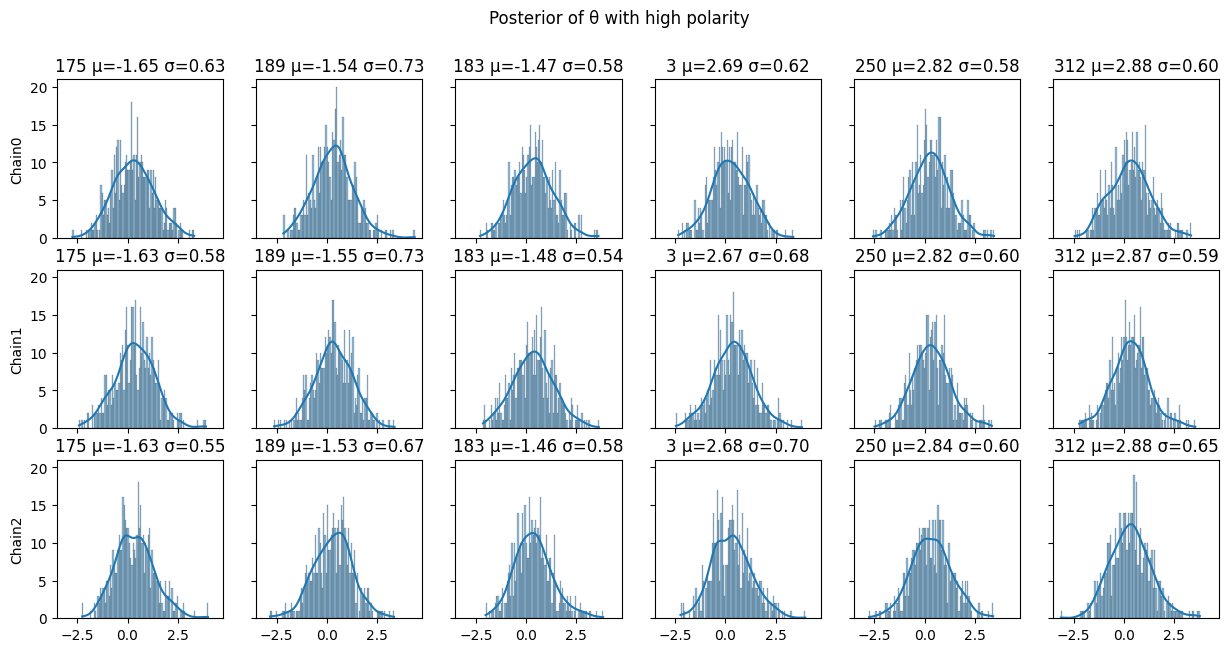

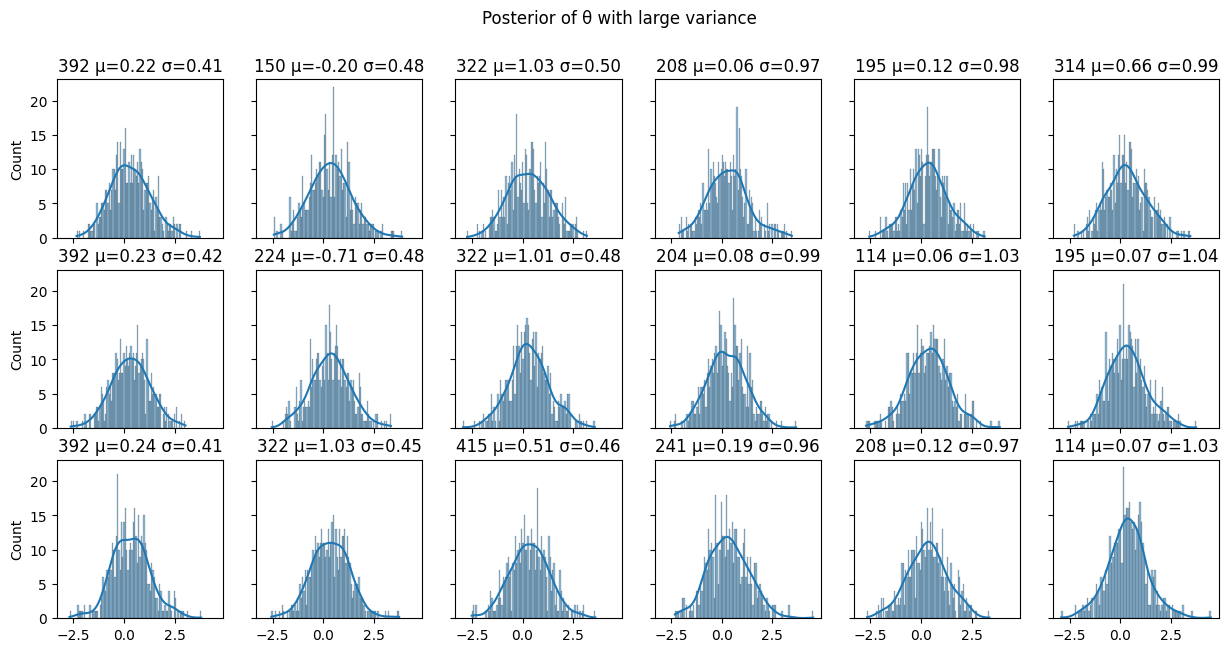

In [23]:
def topn_indices(array, K=3, decending=False):
    if decending is True:
        array = -array
    unsorted_max_indices = np.argpartition(array, K)[:K]
    y = array[unsorted_max_indices]
    indices = np.argsort(-y)
    max_k_indices = unsorted_max_indices[indices]
    return max_k_indices if decending else np.flip(max_k_indices)

fig1, ax1 = plt.subplots(3, 6, figsize=(15,7), sharey=True, sharex=True)
for c in range(len(chains)):
    for i, j in enumerate(list(topn_indices(chains_mean[c])) + list(topn_indices(chains_mean[c], decending=True))):
        sns.histplot(chains[c][j], bins=100, ax=ax1[c, i], kde=True) \
        .set_title(f"{j} μ={chains_mean[c][j]:.2f} σ={chains_std[c][j]:.2f}");
        ax1[c, i].set_ylabel(f"Chain{c}")
fig1.suptitle("Posterior of θ with high polarity");

fig2, ax2 = plt.subplots(3, 6, figsize=(15,7), sharey=True, sharex=True)
for c in range(len(chains)):
    for i, j in enumerate(list(topn_indices(chains_std[c])) + list(topn_indices(chains_std[c], decending=True))):
        sns.histplot(chains[c][j], bins=100, ax=ax2[c, i], kde=True) \
        .set_title(f"{j} μ={chains_mean[c][j]:.2f} σ={chains_std[c][j]:.2f}");
        ax1[c, i].set_ylabel(f"Chain{c}")
fig2.suptitle("Posterior of θ with large variance");

In [24]:
%%R
# 一番正の極性が大きく推定されたやつ、人手評価は 4
s <- ys %>% slice(312)
cat(paste(s$scale, '\n'))
cat(as.character(corpus[312]))

4 
\Perhaps ((no) not one) not Clinton Administration gets as fired up as Alice M . Rivlin about eliminating the Federal budget deficit . As director of the Office of Management and Budget since October 1994 and deputy director for 20 months before x she has been a powerful voice for xbalance budget x and in this her views are strongly akin to those of Alan Greenspan x the Fed's chairman . \But Administration colleagues took pains to make clear that Ms Rivlin x nominated yesterday to be the Fed's vice chairman x would not favor policies that took income away from Americans unnecessarily . And x they said x Ms Rivlin x 64 x would bring to the Fed a backbone that is likely to make her as sturdy a point person for the Administration as her predecessor x Alan S . Blinder x although (less) not public about it . \ Still x Ms Rivlin holds views on economic growth that sometimes seem closer to those of Mr Greenspan than to those of Mr Clinton x who has suggested that the economy might benefit 

In [25]:
%%R
# 一番負の極性が小さく推定されたやつ、人手評価は 1
s <- ys %>% slice(175)
cat(paste(s$scale, '\n'))
cat(as.character(corpus[175]))

1 
\Officials of the nation's cities have given Congress and the Reagan Administration a ''lousy report card'' on how Washington handles key issues from drugs to the deficit x according to the National League of Cities . \In a survey of 596 local officials by the league x Washington's work received average ratings of poor to inferior on six policy issues . The issues were illegal drugs x housing x disposal of hazardous materials x unemployment x poverty and the Federal deficit . \Congress received the worst mark x for its handling of the deficit problem x and the second lowest was given the Administration for the same issue . Both grades were under 1 x which is a ''D ,'' or ''poor ,'' on the scale . A score of 0 was an ''F ,'' or ''inferior ,'' while 4 was an ''A ,'' or ''excellent .'' Leaders Are 'Playing Hooky' \''By any standard x this is a lousy report card for our national leaders ,'' Alan Beals x executive director of the League of Cities x said in releasing the survey's results 

In [26]:
# SVI (numpyro)

In [27]:
from numpyro.infer import SVI, Trace_ELBO

def guide(data):
    M = data[0]
    with numpyro.plate('M', M):
        mu_q = numpyro.param("mu_q", 0.)
        sigma_q = numpyro.param("sigma_q", 1.)
        numpyro.sample("latent_fairness", dist.Normal(mu_q, sigma_q))

data = (M, N, V, D, W, p_v, phi)
optimizer = numpyro.optim.Adam(step_size=0.0005)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
svi_state = svi.init(random.PRNGKey(0), data)
svi_result = svi.run(random.PRNGKey(1), 1000, data)

  0%|                                                                                                                                                                                                                | 0/1000 [00:00<?, ?it/s]/workspaces/lss/.venv/lib/python3.10/site-packages/jax/_src/linear_util.py:396: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'latent_fairness'}
  ans = _fun(*args, **kwargs)
/workspaces/lss/.venv/lib/python3.10/site-packages/jax/_src/linear_util.py:396: UserWarning: Found vars in model but not guide: {'theta'}
  ans = _fun(*args, **kwargs)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:47<00:00,  3.48it/s, init loss: 548590.1250, avg. loss [951-1000]: 548379.3375]


In [28]:
# MAP Estimation (numpyro)

In [29]:
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoDelta

guide = AutoDelta(model)
optimizer = numpyro.optim.Adam(step_size=0.0005)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
rng_key = random.PRNGKey(0)
svi_result = svi.run(rng_key, 2000, (M, N, V, D, W, p_v, phi))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [22:46<00:00,  1.46it/s, init loss: 548721.5625, avg. loss [1901-2000]: 548425.4244]


In [30]:
# MAP Estimation (stan)

In [31]:
%%R
stanmodel <- stan_model(file="./plss.stan")

In [32]:
%%R -i N,M,V,D,W,p_v,phi
data <- list(
  N=N,
  M=M,
  V=V,
  D=D+1,
  W=W+1,
  p_v=p_v,
  phi=phi
)

fit_stan <- optimizing(stanmodel, data=data, seed=1234, verbose = TRUE)

Chain 1: Initial log joint probability = -505871
Chain 1:     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Chain 1:        8       -504944     0.0463765     0.0332285           1           1       11   
Chain 1: Optimization terminated normally: 
Chain 1:   Convergence detected: relative gradient magnitude is below tolerance


In [33]:
%%R
vb_stan <- vb(stanmodel, data=data, output_samples=1000, seed=1234)

Chain 1: ------------------------------------------------------------
Chain 1: EXPERIMENTAL ALGORITHM:
Chain 1:   This procedure has not been thoroughly tested and may be unstable
Chain 1:   or buggy. The interface is subject to change.
Chain 1: ------------------------------------------------------------
Chain 1: 
Chain 1: 
Chain 1: 
Chain 1: Gradient evaluation took 13.4129 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 134129 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Begin eta adaptation.
Chain 1: Iteration:   1 / 250 [  0%]  (Adaptation)
Chain 1: Iteration:  50 / 250 [ 20%]  (Adaptation)
Chain 1: Iteration: 100 / 250 [ 40%]  (Adaptation)
Chain 1: Iteration: 150 / 250 [ 60%]  (Adaptation)
Chain 1: Iteration: 200 / 250 [ 80%]  (Adaptation)
Chain 1: Success! Found best value [eta = 1] earlier than expected.
Chain 1: 
Chain 1: Begin stochastic gradient ascent.
Chain 1:   iter             ELBO   delta_ELBO_m

警告: Pareto k diagnostic value is 1.57. Resampling is disabled. Decreasing tol_rel_obj may help if variational algorithm has terminated prematurely. Otherwise consider using sampling instead.


In [34]:
# 人手評価との比較

In [35]:
%%R
get_theta <- function(fit) {
    theta <- names(fit$par) %>% 
        str_detect('theta') %>% 
        keep(fit$par, .)
    return (theta)
}
    
boxplot <- function(ys, theta, name) {
    result <- tibble(
        scale = ys$scale,
        theta = theta
    )
    #ggplot(data = result, mapping = aes(x = theta)) +
    #  geom_histogram(bins = 50)

    gg <- ggplot(data = result, mapping = aes(x = theta, y = scale, group = scale)) +
    #    geom_boxplot(outlier.size = 2,
    #                 outlier.shape = 21,
    #                 outlier.colour = "red") +
            geom_boxplot(outlier.colour = NA) +
            geom_point(size = 1.0, position = position_jitter(width = 0.2, height = 0.2, seed = 123L)) +
    #        geom_point(size = 1.0) +
            labs(title = paste(name, " (corr", " = ", round(cor(ys$scale, theta, method="pearson"), digits = 3), ")"),
                 x = "theta",
                 y = "human")
    return(gg)
}

In [36]:
%%R -i theta_mcmc_mean
g_mcmc_numpyro <- boxplot(ys, theta_mcmc_mean, "MCMC (numpyro)")
g_map_stan <- boxplot(ys, get_theta(fit_stan), "MAP (Stan)")

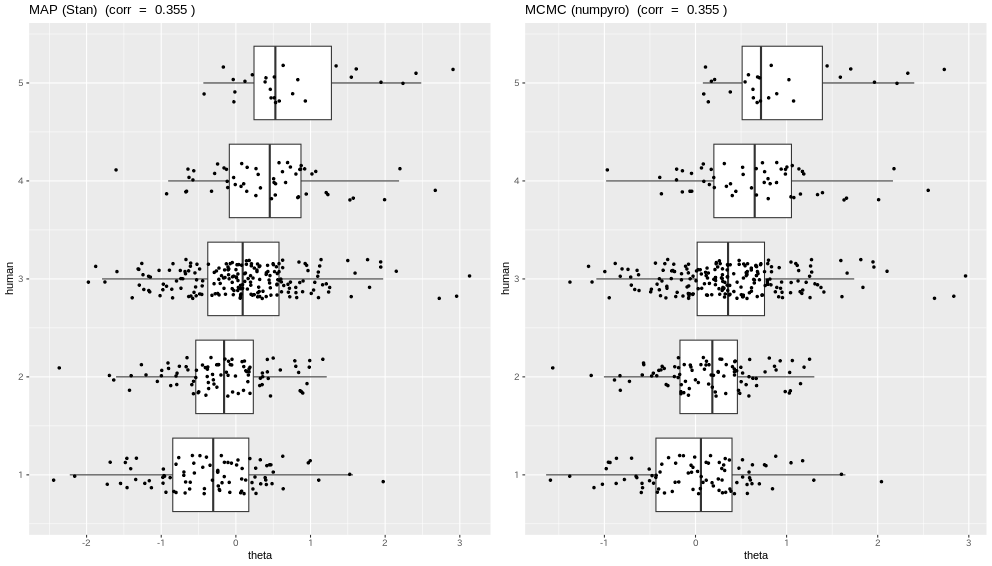

In [37]:
%%R -w 35 -h 20 --units cm
gridExtra::grid.arrange(g_map_stan, g_mcmc_numpyro, ncol = 2);

In [38]:
%%R
# 人手評価と一致するサンプル
scale <- ys$scale
body <- ys$body
result <- tibble(scale, theta_mcmc_mean, body) %>%
        arrange(desc(scale), desc(theta_mcmc_mean))
head(result, n=3)

# A tibble: 3 × 3
  scale theta_mcmc_mean body                                                    
  <dbl>       <dbl[1d]> <chr>                                                   
1     5            2.83 "\\Grammys can be spelled another way: P A R T I E S x …
2     5            2.40 "\\Two and a half years ago x as seniors at St Peter's …
3     5            2.14 "\\Following is a transcript of President Reagan's addr…


In [39]:
%%R
scale <- ys$scale
body <- ys$body
result <- tibble(scale, theta_mcmc_mean, body) %>%
        arrange(scale, theta_mcmc_mean)
head(result, n=3)

# A tibble: 3 × 3
  scale theta_mcmc_mean body                                                    
  <dbl>       <dbl[1d]> <chr>                                                   
1     1           -1.64 "\\IS the economy on the verge of a recession . \\There…
2     1           -1.45 "\\President Reagan x campaigning to protect the Republ…
3     1           -1.07 "\\The yen's sudden jump against the dollar this past w…
